In [ ]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [ ]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

In [ ]:
!ls dataset
print("")
!ls dataset/all
print("")
!ls dataset/train
print("")
!ls dataset/valid

all  train  valid

charles_dexter_ward.txt  doorstep.txt		  moon_bog.txt	     shunned_house.txt
clergyman.txt		 gates_of_silver_key.txt  pharoahs.txt	     temple.txt
cool_air.txt		 high_house_mist.txt	  pickman.txt	     tree.txt
cthulhu.txt		 lurking_fear.txt	  picture_house.txt  vault.txt
dagon.txt		 memory.txt		  sarnath.txt	     white_ship.txt

charles_dexter_ward.txt  dagon.txt	      pharoahs.txt	 temple.txt
clergyman.txt		 doorstep.txt	      pickman.txt	 tree.txt
cool_air.txt		 high_house_mist.txt  picture_house.txt  vault.txt
cthulhu.txt		 memory.txt	      shunned_house.txt  white_ship.txt

gates_of_silver_key.txt  lurking_fear.txt  moon_bog.txt  sarnath.txt


# Access the files

In [ ]:
batch_size = 32
seed = 666

def create_dataset(dataset_path):
  assert os.path.exists(dataset_path)

  dataset = preprocessing.text_dataset_from_directory(
      dataset_path,
      seed=seed,
      labels=None,
      # Classes generated from subdirectory of data dir if labels was not set to none
      batch_size=batch_size
  )

  return dataset

dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)


Found 20 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


In [ ]:
for batch in dataset_original_all:
  print(batch)
  break

tf.Tensor(
[b'COOL AIR\n\nYou ask me to explain why I am afraid of a draught of cool air; why I shiver more than others upon entering a cold room, and seem nauseated and repelled when the chill of evening creeps through the heat of a mild autumn day. There are those who say I respond to cold as others do to a bad odour, and I am the last to deny the impression. What I will do is to relate the most horrible circumstance I ever encountered, and leave it to you to judge whether or not this forms a suitable explanation of my peculiarity.\n\nIt is a mistake to fancy that horror is associated inextricably with darkness, silence, and solitude. I found it in the glare of mid-afternoon, in the clangour of a metropolis, and in the teeming midst of a shabby and commonplace rooming-house with a prosaic landlady and two stalwart men by my side. In the spring of 1923 I had secured some dreary and unprofitable magazine work in the city of New York; and being unable to pay any substantial rent, began 

# Create the text vectorizer

In [ ]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    split='whitespace',
    output_mode='int'
)

encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()

In [ ]:
print(vocabulary)

['', '[UNK]', 'the', 'and', 'of', 'to', 'a', 'in', 'was', 'I', 'that', 'had', 'he', 'his', 'with', 'which', 'as', 'from', 'at', 'for', 'it', 'not', 'on', 'but', 'were', 'by', 'my', 'The', 'or', 'be', 'have', 'an', 'this', 'could', 'all', 'no', 'one', 'when', 'they', 'been', 'me', 'would', 'him', 'some', 'so', 'is', 'what', 'It', 'He', 'there', 'its', 'their', 'only', 'more', 'you', 'out', 'very', 'did', 'seemed', 'about', 'old', 'who', 'than', 'up', 'any', 'now', 'into', 'after', 'must', 'through', 'where', 'we', 'time', 'Ward', 'if', 'found', 'before', 'whose', 'saw', 'even', 'those', 'great', 'might', 'man', 'like', 'them', 'And', 'other', 'such', 'In', 'are', 'though', 'over', 'came', 'down', 'upon', 'never', 'Willett', 'still', 'There', 'these', 'two', 'strange', 'Charles', 'things', 'certain', 'But', 'made', 'ever', 'much', 'Dr.', 'first', 'long', 'her', 'will', 'most', 'told', 'almost', 'yet', 'knew', 'heard', 'can', 'Mr.', 'once', 'Curwen', 'many', 'last', 'men', 'ancient', 'hou

In [ ]:
sequence_length = 32 # Length of group which serves as context to predict next word
padding_token_id = 0

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []

  for books in dataset:

    for book in tqdm(books):
      book = encoder(book).numpy().tolist() # encoding the book, convert to numpy and unravel
      padding = [padding_token_id] * 32 # create 32 empty entries
      book = padding + book

      # Now the book is vectorized (all ints) and we have padding at the beginning to generate from emptiness.

      for start_index in range(0, len(book) - sequence_length):
        x = book[start_index:start_index + sequence_length]
        y = book[start_index + sequence_length]
        assert len(x) == sequence_length

        x_inputs.append(x)
        y_outputs.append(y)

  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))


dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)
print("Done!")

100%|██████████| 4/4 [00:00<00:00, 12.37it/s]


Done!


In [ ]:
for x, y in dataset_train.take(5):
  print(x.numpy().tolist(),y.numpy())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1] 324
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 324] 636
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 324, 636] 40


In [ ]:
def decode(indices):

  words = [vocabulary[index] for index in indices if index != padding_token_id]
  return " ".join(words)

for input, output in dataset_train.shuffle(100).take(10):
  #print(input)
  print(decode(input.numpy()))
  #print(output)
  print(decode([output.numpy()]))
  print("")

[UNK] [UNK] You ask me to explain
why

There are those who say I respond to cold as others do to a bad [UNK] and I am the last to deny the [UNK] What I will do is to relate
the

am the last to deny the [UNK] What I will do is to relate the most horrible circumstance I ever [UNK] and leave it to you to judge whether or not this
forms

me to explain why I am afraid of a draught of cool [UNK] why I shiver more than others upon entering a cold room, and seem [UNK] and repelled when the chill
of

[UNK] through the heat of a mild autumn day. There are those who say I respond to cold as others do to a bad [UNK] and I am the last to deny
the

I am afraid of a draught of cool [UNK] why I shiver more than others upon entering a cold room, and seem [UNK] and repelled when the chill of evening [UNK] through
the

[UNK] [UNK] You ask me to explain why I am afraid of a draught of cool [UNK] why I shiver more than others upon entering a cold room, and seem [UNK]
and

who say I respond to cold as other

In [ ]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

# Training!

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, 16, input_length=sequence_length))
model.add(layers.LSTM(32))
model.add(layers.Dense(vocabulary_size, activation="softmax")) # multiclassification, prediction of probability function

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 16)            160000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 10000)             330000    
                                                                 
Total params: 496272 (1.89 MB)
Trainable params: 496272 (1.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
249/249 [==============================] - 32s 118ms/step - loss: 6.7725 - accuracy: 0.0789 - val_loss: 6.7042 - val_accuracy: 0.0872
Epoch 2/100
249/249 [==============================] - 11s 46ms/step - loss: 6.4618 - accuracy: 0.0918 - val_loss: 6.6779 - val_accuracy: 0.0872
Epoch 3/100
249/249 [==============================] - 8s 33ms/step - loss: 6.4088 - accuracy: 0.0918 - val_loss: 6.6725 - val_accuracy: 0.0872
Epoch 4/100
249/249 [==============================] - 6s 26ms/step - loss: 6.3515 - accuracy: 0.1050 - val_loss: 6.6548 - val_accuracy: 0.1112
Epoch 5/100
249/249 [==============================] - 5s 20ms/step - loss: 6.2991 - accuracy: 0.1091 - val_loss: 6.6550 - val_accuracy: 0.1144
Epoch 6/100
249/249 [==============================] - 4s 17ms/step - loss: 6.2640 - accuracy: 0.1072 - val_loss: 6.6525 - val_accuracy: 0.1101
Epoch 7/100
249/249 [==============================] - 5s 21ms/step - loss: 6.2279 - accuracy: 0.1171 - val_loss: 6.6407 - val_accura

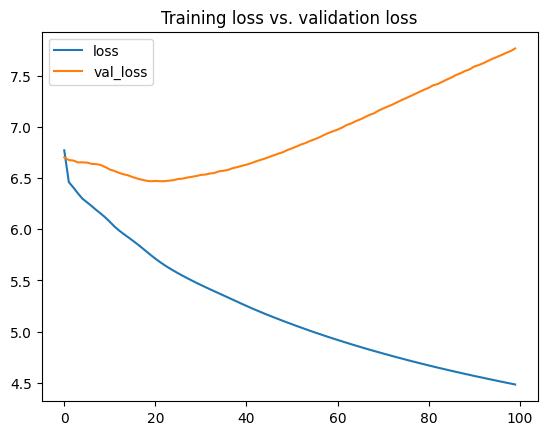

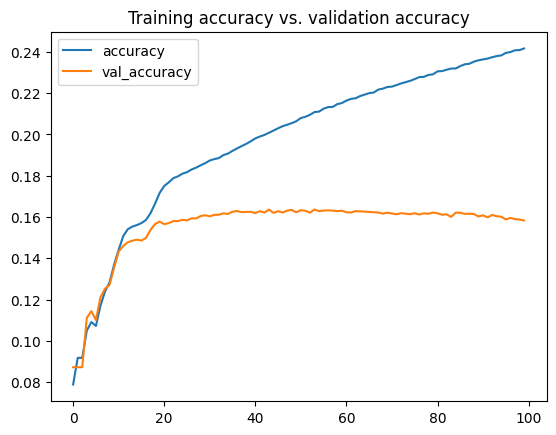

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", # not binary crossentropy because of multiclass issue. Target is only 1 number, input 10_000 --> sparse (or alt: hot-encoding)
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(100_000).batch(512),
    validation_data=dataset_valid.cache().batch(512),
    epochs=100
)

render_history(history)

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)

we are all doomed [UNK] but must be there. It was the imaginary location of the vindictive yacht, that filled at the town; and you talk before. story we knew my [UNK] later far flung broke from Salem during the under my dark wall whose foul [UNK] likeness to join the crest of the room through the little domes and [UNK] can [UNK] unaccountably ships him. The dismal decade was possible mad or in no horrors in mind against a tremor to be essential Willett confessed that that the man heard the rays of the conning tower. Eight distinction near



In [ ]:
# Play with:
# epochs, vocab size, punctuation, temperature